In [1]:
import os
from matplotlib import pyplot as plt
import matplotlib
import tensorflow as tf
import tensorflow_io as tfio
import librosa
import numpy as np
import pandas as pd
import csv
import glob
import math
import random

In [2]:
from audiomentations import Compose, Gain, AddGaussianNoise, TimeMask, AddShortNoises, PolarityInversion, AirAbsorption, RepeatPart, Shift, AdjustDuration

In [3]:
!python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
val_NEG = os.path.join('belize-data', 'Validation data', 'Background')
val_POS = os.path.join('belize-data', 'Validation data', 'Gunshot')
train_NEG = os.path.join('belize-data', 'Training data', 'Background')
train_POS = os.path.join('belize-data', 'Training data', 'Gunshot')

In [115]:
val_neg = glob.glob(val_NEG+'/*.wav')
val_pos = glob.glob(val_POS+'/*.wav')
train_neg = glob.glob(train_NEG+'/*.wav')
train_pos = glob.glob(train_POS+'/*.wav')

def label(d, label):
    i=0
    for element in d:
        element = d[i]
        d[i] = [element, label]
        i = i+1
    return d

a = label(val_neg, 0)
b = label(val_pos, 1)
c = label(train_neg, 0)
d = label(train_pos, 1)

e = a+b+c+d

e_shuffled = random.shuffle(e)

tt = math.floor(0.8*len(e))+1
tv = len(e)-tt

print(tt)
print(tv)

28785
7195


In [6]:
def label(d, cl):
    i=0
    for element in d:
        element = d[i]
        d[i] = [element, cl]
        i = i+1
    return d

In [7]:
def load_wav_8k_mono(filename):
    try:
        file_contents = tf.io.read_file(filename)
        wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
        sample_rate = tf.cast(sample_rate, dtype=tf.int64)
        if sample_rate != 8000:
            wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=8000)
        wav = tf.squeeze(wav, axis=-1)
    except Exception as e:
        print(f"Invalid file: {filename} - {e}")
    return wav

In [8]:
def load_wav_tuple(filename, label):
    wav = load_wav_8k_mono(filename)
    return wav, label

In [9]:
def change_label_type(filename, label):
    label = int(label)
    label = tf.cast(label, tf.float32)
    return filename, label

In [10]:
def preprocess_reg(file_path, label):
    sample_rate = 8000
    reg_spec_length = 32000
    frame_length = 256
    frame_step = 128
    # load wav and make sure length is proper
    if isinstance(file_path, str):
        try:
            wav, label = load_wav_8k_mono(file_path)
        except Exception as e:
            print(f"Failed to load wav file at {file_path} - {e}")
    else:
        wav = file_path

    if len(wav) > 32000:
        wav = wav[:reg_spec_length]
    if len(wav) < 32000:
        try:
            zero_padding = tf.zeros([reg_spec_length] - tf.shape(wav), dtype=tf.float32)
            wav = tf.concat([zero_padding, wav], 0)
        except Exception as e:
            print(f"Failed to pad wav file at {file_path} - {e}")
    
    #norm_wav = (wav - (tf.reduce_min(wav)))/((tf.reduce_max(wav))-(tf.reduce_min(wav))+1e-8)
    #wav = norm_wav
    
    # create the spectrogram
    print("Wav Shape:", wav.shape)
    spectrogram = tf.signal.stft(wav, frame_length, frame_step, window_fn=tf.signal.hann_window)
    print("STFT Shape1:", spectrogram.shape)
    spectrogram = tf.abs(spectrogram)
    print("STFT Shape2:", spectrogram.shape)
    
    # add a dimension
    reg_spectrogram = tf.expand_dims(spectrogram, axis=2)
    print("Reg Spectrogram Shape2:", reg_spectrogram.shape)

    return reg_spectrogram, label

In [11]:
def preprocess_mel(file_path, label):
    sample_rate = 8000
    mel_spec_length = 32000
    frame_length = 256
    frame_step = 128
    mel_bins = 64
    upper_edge = 4000
    lower_edge = 0
    # load wav and make sure length is proper
    if isinstance(file_path, str):
        try:
            wav, label = load_wav_8k_mono(file_path)
        except Exception as e:
            print(f"Failed to load wav file at {file_path} - {e}")
    else:
        wav = file_path

    if len(wav) > 32000:
        wav = wav[:mel_spec_length]
    if len(wav) < 32000:
        try:
            zero_padding = tf.zeros([mel_spec_length] - tf.shape(wav), dtype=tf.float32)
            wav = tf.concat([zero_padding, wav], 0)
        except Exception as e:
            print(f"Failed to pad wav file at {file_path} - {e}")
    
    norm_wav = (wav - (tf.reduce_min(wav)))/((tf.reduce_max(wav))-(tf.reduce_min(wav))+1e-8)
    #wav = norm_wav
    
    # create the spectrogram
    print("Wav Shape:", wav.shape)
    spectrogram = tf.signal.stft(wav, frame_length, frame_step, window_fn=tf.signal.hann_window)
    print("STFT Shape1:", spectrogram.shape)
    spectrogram = tf.abs(spectrogram)
    print("STFT Shape2:", spectrogram.shape)

    # create the mel filterbank
    spec_bins = frame_length // 2 + 1  # Derived from frame length
    mel_filterbank = tf.signal.linear_to_mel_weight_matrix(
        64,
        spec_bins,
        sample_rate,
        lower_edge,
        upper_edge,
    )
    print("Mel Filterbank Shape:", mel_filterbank.shape)
    
    # create the mel spectrogram
    mel_spectrogram = tf.matmul(spectrogram, mel_filterbank)
    print("Mel Spectrogram Shape1:", mel_spectrogram.shape)

    # add a dimension
    mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=2)
    print("Mel Spectrogram Shape2:", mel_spectrogram.shape)

    return mel_spectrogram, label

In [12]:
def preprocess_pcen_old(file_path):
    sample_rate = 8000
    mel_spec_length = 32000
    frame_length = 256
    frame_step = 128
    mel_bins = 64
    upper_edge = 4000
    lower_edge = 0
    # load wav and make sure length is proper
    wav, sr = librosa.load(file_path, sr=sample_rate, mono=True)
    
    if len(wav) > 32000:
        wav = wav[:mel_spec_length]
    if len(wav) < 32000:
        try:
            wav = librosa.util.fix_length(wav, size=32000)
        except Exception as e:
            print(f"Failed to pad wav file at {file_path} - {e}")

    # create melspec and apply pcen
    mel_spectrogram = librosa.feature.melspectrogram(y=wav, sr=8000, fmin=0, fmax=4000,
        hop_length=256, n_mels=64)
    
    pcen = librosa.core.pcen(mel_spectrogram, sr=8000, gain=0.8, bias=10,
        power=0.25, hop_length=frame_step,
        time_constant=0.06, eps=1e-06)
    
    # trim
    mel_spectrogram = mel_spectrogram[:, :249]
    # add a dimension
    #print("Mel Spectrogram Shape2:", mel_spectrogram.shape)
    mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=2)
    #print("Mel Spectrogram Shape3:", mel_spectrogram.shape)
    mel_spectrogram = tf.transpose(mel_spectrogram, [1, 0, 2])
    #print("Mel Spectrogram Shape4:", mel_spectrogram.shape)
    
    return mel_spectrogram

In [61]:
def preprocess_librosa_mel(input_data, label):
    sample_rate = 8000
    mel_spec_length = 32000
    frame_length = 256
    frame_step = 128
    mel_bins = 64
    upper_edge = 4000
    lower_edge = 0

    # Determine if input_data is a file path or already audio data.
    # (Note: In a tf.data pipeline, input_data will be a tf.Tensor.)
    if isinstance(input_data, tf.Tensor):
        # If the tensor is a string, assume it is a file path.
        # Otherwise, if it’s a float tensor, assume it’s already the loaded audio.
        if input_data.dtype == tf.string:
            # Convert to a Python string.
            file_path = input_data.numpy().decode('utf-8')
            wav, sr = librosa.load(file_path, sr=sample_rate, mono=True)
        elif input_data.dtype in (tf.float32, tf.float64):
            # Already loaded audio.
            # (In eager mode, you can convert to a numpy array.)
            wav = input_data.numpy()
            sr = sample_rate
        else:
            raise TypeError("Unexpected tensor type: {}".format(input_data.dtype))
    elif isinstance(input_data, str):
        # If it is a Python string, load the file.
        wav, sr = librosa.load(input_data, sr=sample_rate, mono=True)
    else:
        # If it’s neither a string nor a tensor, assume it’s already audio.
        wav = input_data
        sr = sample_rate

    # Ensure wav is exactly mel_spec_length samples.
    if len(wav) > mel_spec_length:
        wav = wav[:mel_spec_length]
    elif len(wav) < mel_spec_length:
        try:
            wav = librosa.util.fix_length(wav, size=mel_spec_length)
        except Exception as e:
            print(f"Failed to pad wav file: {e}")

    # Create the mel spectrogram and apply PCEN.
    mel_spectrogram = librosa.feature.melspectrogram(y=wav, sr=sample_rate, fmin=100, fmax=4000,
                                                     hop_length=128, n_mels=64)
    pcen = librosa.core.pcen(mel_spectrogram, sr=sample_rate, gain=0.8, bias=10,
                             power=0.25, hop_length=frame_step, time_constant=0.06, eps=1e-06)
    #mel_spectrogram = pcen
    
    #print(mel_spectrogram.shape)
    # trim to proper input shape
    mel_spectrogram = mel_spectrogram[:, :249]
    #print(mel_spectrogram.shape)
    # Transpose so that the final shape is (time, mel_bins) = (249, 64) and then add a channel.
    mel_spectrogram = np.transpose(mel_spectrogram)  # (249, 64)
    #print(mel_spectrogram.shape)
    mel_spectrogram = np.expand_dims(mel_spectrogram, axis=2)  # (249, 64, 1)
    #print(mel_spectrogram.shape)

    return mel_spectrogram.astype(np.float32), label

In [56]:
def preprocess_pcen(input_data, label):
    sample_rate = 8000
    mel_spec_length = 32000
    frame_length = 256
    frame_step = 128
    mel_bins = 64
    upper_edge = 4000
    lower_edge = 0

    # Determine if input_data is a file path or already audio data.
    # (Note: In a tf.data pipeline, input_data will be a tf.Tensor.)
    if isinstance(input_data, tf.Tensor):
        # If the tensor is a string, assume it is a file path.
        # Otherwise, if it’s a float tensor, assume it’s already the loaded audio.
        if input_data.dtype == tf.string:
            # Convert to a Python string.
            file_path = input_data.numpy().decode('utf-8')
            wav, sr = librosa.load(file_path, sr=sample_rate, mono=True)
        elif input_data.dtype in (tf.float32, tf.float64):
            # Already loaded audio.
            # (In eager mode, you can convert to a numpy array.)
            wav = input_data.numpy()
            sr = sample_rate
        else:
            raise TypeError("Unexpected tensor type: {}".format(input_data.dtype))
    elif isinstance(input_data, str):
        # If it is a Python string, load the file.
        wav, sr = librosa.load(input_data, sr=sample_rate, mono=True)
    else:
        # If it’s neither a string nor a tensor, assume it’s already audio.
        wav = input_data
        sr = sample_rate

    # Ensure wav is exactly mel_spec_length samples.
    if len(wav) > mel_spec_length:
        wav = wav[:mel_spec_length]
    elif len(wav) < mel_spec_length:
        try:
            wav = librosa.util.fix_length(wav, size=mel_spec_length)
        except Exception as e:
            print(f"Failed to pad wav file: {e}")

    # Create the mel spectrogram and apply PCEN.
    mel_spectrogram = librosa.feature.melspectrogram(y=wav, sr=sample_rate, fmin=100, fmax=4000,
                                                     hop_length=128, n_mels=64)
    pcen = librosa.core.pcen(mel_spectrogram, sr=sample_rate, gain=0.8, bias=10,
                             power=0.25, hop_length=frame_step, time_constant=0.06, eps=1e-06)
    mel_spectrogram = pcen
    
    #print(mel_spectrogram.shape)
    # Trim to proper input shape (251 --> 249 mel_bins)
    mel_spectrogram = mel_spectrogram[:, :249]
    #print(mel_spectrogram.shape)
    # Transpose so that the final shape is (time, mel_bins) = (249, 64) and then add a channel.
    mel_spectrogram = np.transpose(mel_spectrogram)  # (249, 64)
    #print(mel_spectrogram.shape)
    mel_spectrogram = np.expand_dims(mel_spectrogram, axis=2)  # (249, 64, 1)
    #print(mel_spectrogram.shape)

    return mel_spectrogram.astype(np.float32), label

In [15]:
def preprocess_pcen_py(input_data, label):
    pcen, label = preprocess_pcen(input_data, label)
    return pcen, label

def preprocess_pcen_wrapper(input_data, label):
    pcen, label = tf.py_function(
        func=preprocess_pcen_py,
        inp=[input_data, label],
        Tout=[tf.float32, tf.float32]  # Adjust output types as needed.
    )
    # Set static shape if known.
    pcen.set_shape([249, 64, 1])
    return pcen, label

In [16]:
def preprocess_librosa_mel_py(input_data, label):
    pcen, label = preprocess_librosa_mel(input_data, label)
    return pcen, label

def preprocess_librosa_mel_wrapper(input_data, label):
    pcen, label = tf.py_function(
        func=preprocess_librosa_mel_py,
        inp=[input_data, label],
        Tout=[tf.float32, tf.float32]  # Adjust output types as needed.
    )
    # Set static shape if known.
    pcen.set_shape([249, 64, 1])
    return pcen, label

belize-data\Training data\Background\5B1E868F.WAV
Wav Shape: (32000,)
STFT Shape1: (249, 129)
STFT Shape2: (249, 129)
Reg Spectrogram Shape2: (249, 129, 1)


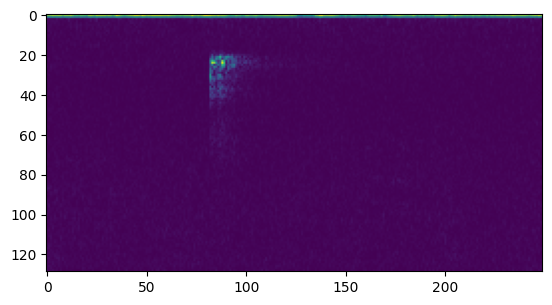

belize-data\Training data\Background\5B1E868F.WAV
Wav Shape: (32000,)
STFT Shape1: (249, 129)
STFT Shape2: (249, 129)
Mel Filterbank Shape: (129, 64)
Mel Spectrogram Shape1: (249, 64)
Mel Spectrogram Shape2: (249, 64, 1)


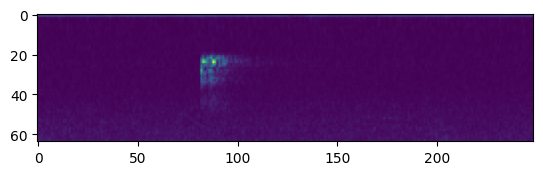

belize-data\Training data\Background\5B1E868F.WAV


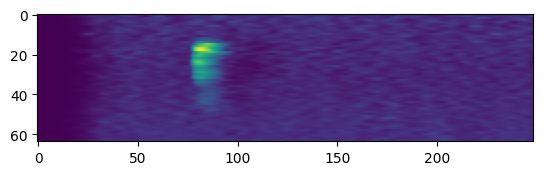

belize-data\Training data\Gunshot\58FFB6942b5f55bf-4990-49d9-a6f3-1000f7046baf.WAV
Wav Shape: (32000,)
STFT Shape1: (249, 129)
STFT Shape2: (249, 129)
Reg Spectrogram Shape2: (249, 129, 1)


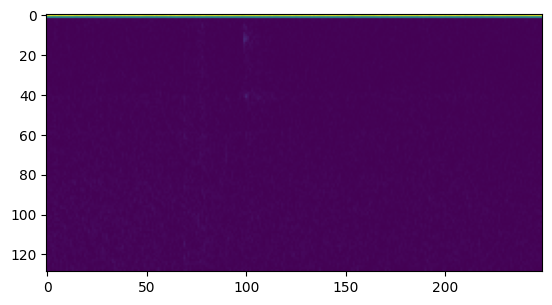

belize-data\Training data\Gunshot\58FFB6942b5f55bf-4990-49d9-a6f3-1000f7046baf.WAV
Wav Shape: (32000,)
STFT Shape1: (249, 129)
STFT Shape2: (249, 129)
Mel Filterbank Shape: (129, 64)
Mel Spectrogram Shape1: (249, 64)
Mel Spectrogram Shape2: (249, 64, 1)


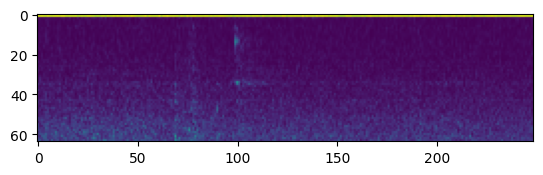

belize-data\Training data\Gunshot\58FFB6942b5f55bf-4990-49d9-a6f3-1000f7046baf.WAV
(249, 64, 1)


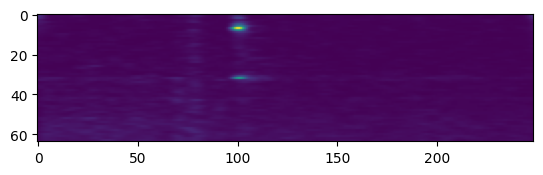

In [60]:
n=21

sample_pos_path = (glob.glob(train_NEG+'/*.wav'))[n]
print(sample_pos_path)
sample_pos_wav = load_wav_8k_mono(sample_pos_path)
sample_pos_melspec, label = preprocess_reg(sample_pos_wav, 1)
plt.figsize=(30,20)
plt.imshow(tf.transpose(sample_pos_melspec)[0])
plt.show()

sample_pos_path = (glob.glob(train_NEG+'/*.wav'))[n]
#sample_pos_path = 'belize-data/Training data/Gunshot/58FFB6942b5f55bf-4990-49d9-a6f3-1000f7046baf.WAV'
print(sample_pos_path)
sample_pos_wav = load_wav_8k_mono(sample_pos_path)
sample_pos_melspec, label = preprocess_mel(sample_pos_wav, 1)
plt.figsize=(30,20)
plt.imshow(tf.transpose(sample_pos_melspec)[0])
plt.show()

sample_pos_path = (glob.glob(train_NEG+'/*.wav'))[n]
#sample_pos_path = 'belize-data/Training data/Gunshot/58FFB6942b5f55bf-4990-49d9-a6f3-1000f7046baf.WAV'
print(sample_pos_path)
sample_pos_pcenspec, label = preprocess_pcen(sample_pos_path, 0)
plt.figsize=(30,20)
plt.imshow(tf.transpose(sample_pos_pcenspec)[0])
#plt.imshow(sample_pos_pcenspec.numpy().squeeze().T, aspect='auto', origin='lower')
plt.show()

sample_pos_path = (glob.glob(train_POS+'/*.wav'))[n]
print(sample_pos_path)
sample_pos_wav = load_wav_8k_mono(sample_pos_path)
sample_pos_melspec, label = preprocess_reg(sample_pos_wav, 1)
plt.figsize=(30,20)
plt.imshow(tf.transpose(sample_pos_melspec)[0])
plt.show()

sample_pos_path = (glob.glob(train_POS+'/*.wav'))[n]
#sample_pos_path = 'belize-data/Training data/Gunshot/58FFB6942b5f55bf-4990-49d9-a6f3-1000f7046baf.WAV'
print(sample_pos_path)
sample_pos_wav = load_wav_8k_mono(sample_pos_path)
sample_pos_melspec, label = preprocess_mel(sample_pos_wav, 1)
plt.figsize=(30,20)
plt.imshow(tf.transpose(sample_pos_melspec)[0])
plt.show()

sample_pos_path = (glob.glob(train_POS+'/*.wav'))[n]
#sample_pos_path = 'belize-data/Training data/Gunshot/58FFB6942b5f55bf-4990-49d9-a6f3-1000f7046baf.WAV'
print(sample_pos_path)
sample_pos_pcenspec, label = preprocess_librosa_mel(sample_pos_path, 1)
plt.figsize=(30,20)
plt.imshow(tf.transpose(sample_pos_pcenspec)[0])
plt.show()

In [14]:
sample_pos_pcenspec

<tf.Tensor: shape=(249, 64, 1), dtype=float32, numpy=
array([[[1.4180968e-03],
        [9.1589015e-04],
        [5.4600497e-04],
        ...,
        [3.2679854e-05],
        [3.8025923e-05],
        [3.8145463e-05]],

       [[1.3180360e-03],
        [8.6004107e-04],
        [5.1553716e-04],
        ...,
        [4.3965767e-05],
        [5.1675910e-05],
        [5.3778625e-05]],

       [[1.0460694e-03],
        [6.9439755e-04],
        [4.2361920e-04],
        ...,
        [5.6031313e-05],
        [6.5874716e-05],
        [7.1153860e-05]],

       ...,

       [[4.7210581e-04],
        [3.2167672e-04],
        [2.7874106e-04],
        ...,
        [7.8378172e-05],
        [7.5701697e-05],
        [9.4287505e-05]],

       [[7.6691253e-04],
        [5.1823759e-04],
        [4.1561213e-04],
        ...,
        [7.0387636e-05],
        [7.2456241e-05],
        [8.8692759e-05]],

       [[1.0848036e-03],
        [7.2200701e-04],
        [5.5642158e-04],
        ...,
        [6.0787006e-

In [15]:
sample_pos_melspec

<tf.Tensor: shape=(249, 64, 1), dtype=float32, numpy=
array([[[0.25065994],
        [0.24196373],
        [0.00496642],
        ...,
        [0.01414004],
        [0.01778504],
        [0.02505632]],

       [[0.2438215 ],
        [0.23514557],
        [0.00236045],
        ...,
        [0.01305224],
        [0.01568151],
        [0.02879461]],

       [[0.24605954],
        [0.23748533],
        [0.00444733],
        ...,
        [0.02932839],
        [0.02267929],
        [0.02206991]],

       ...,

       [[0.24705422],
        [0.23832396],
        [0.00308297],
        ...,
        [0.01322765],
        [0.02386627],
        [0.02550047]],

       [[0.24941659],
        [0.24132507],
        [0.01133579],
        ...,
        [0.02189042],
        [0.0172018 ],
        [0.02281997]],

       [[0.24481618],
        [0.23660086],
        [0.00801783],
        ...,
        [0.02053264],
        [0.03512896],
        [0.02422094]]], dtype=float32)>

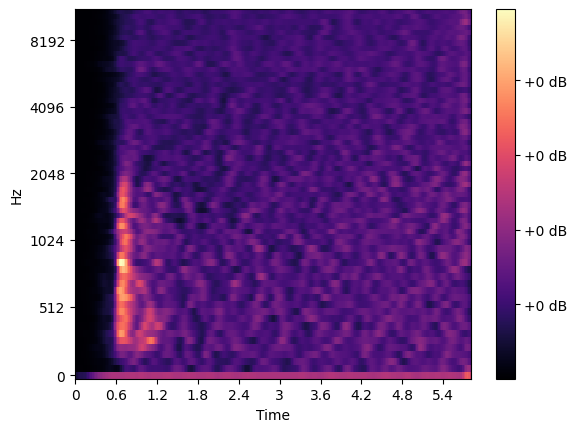

In [17]:
fig, ax = plt.subplots()
sample_pos_path = (glob.glob(train_POS+'/*.wav'))[4]
sample_pos_wav, sr = librosa.load(sample_pos_path, sr=8000, mono=True)
M = librosa.feature.melspectrogram(y=sample_pos_wav, sr=8000, fmin=0, fmax=4000,
        hop_length=128, n_mels=64)
pcen = librosa.core.pcen(M, sr=8000, gain=0.8, bias=10,
        power=0.25, hop_length=128,
        time_constant=0.06, eps=1e-06)
img = librosa.display.specshow(pcen, y_axis='mel', x_axis='time', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

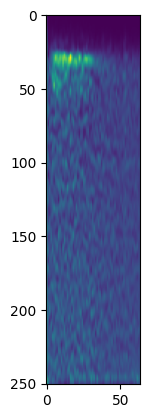

In [21]:
fig, ax = plt.subplots()
sample_pos_path = (glob.glob(train_POS+'/*.wav'))[4]
sample_pos_wav, sr = librosa.load(sample_pos_path, sr=8000, mono=True)
M = librosa.feature.melspectrogram(y=sample_pos_wav, sr=8000, fmin=0, fmax=4000,
        hop_length=128, n_mels=64)
pcen = librosa.core.pcen(M, sr=8000, gain=0.8, bias=10,
        power=0.25, hop_length=128,
        time_constant=0.06, eps=1e-06)
pcen = tf.expand_dims(pcen, axis=2)
plt.figsize=(30,20)
plt.imshow(tf.transpose(pcen)[0])
plt.show()

belize-data\Training data\Gunshot\58FFB612f7cd1675-9592-4924-9361-67455e22d1c6.WAV


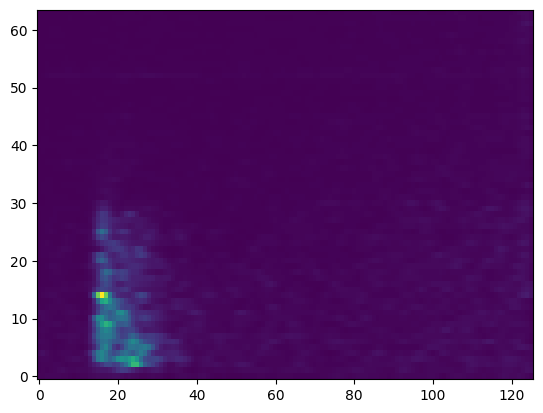

In [97]:
sample_pos_path = (glob.glob(train_POS+'/*.wav'))[4]
print(sample_pos_path)
sample_pos_pcenspec = preprocess_pcen(sample_pos_path)
plt.figsize=(30,20)
plt.imshow(sample_pos_pcenspec.numpy().squeeze().T, aspect='auto', origin='lower')
plt.show()

belize-data\Training data\Background\5B1E8226.WAV
Wav Shape: (32000,)
STFT Shape1: (249, 129)
STFT Shape2: (249, 129)
Mel Filterbank Shape: (129, 64)
Mel Spectrogram Shape1: (249, 64)
Mel Spectrogram Shape2: (249, 64, 1)


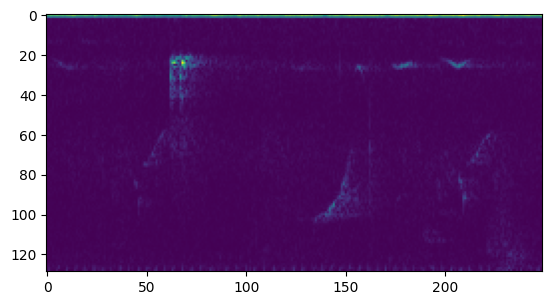

In [129]:
sample_pos_path = (glob.glob(train_NEG+'/*.wav'))[4]
print(sample_pos_path)
sample_pos_wav = load_wav_8k_mono(sample_pos_path)
sample_pos_pcenspec, label = preprocess_mel(sample_pos_wav, 1)
plt.figsize=(30,20)
#plt.imshow(sample_pos_pcenspec.numpy().squeeze().T, aspect='auto', origin='lower')
plt.imshow(tf.transpose(sample_pos_melspec)[0])
plt.show()

belize-data\Training data\Background\5B1E8226.WAV
Wav Shape: (32000,)
STFT Shape1: (249, 129)
STFT Shape2: (249, 129)
Reg Spectrogram Shape2: (249, 129, 1)


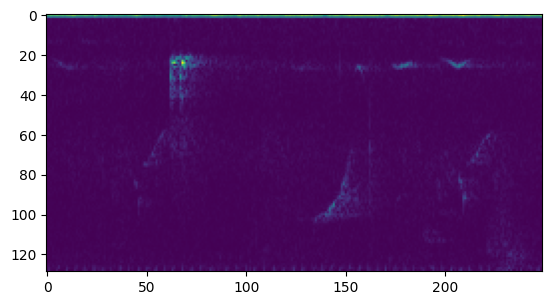

In [128]:
sample_pos_path = (glob.glob(train_NEG+'/*.wav'))[4]
print(sample_pos_path)
sample_pos_wav = load_wav_8k_mono(sample_pos_path)
sample_pos_melspec, label = preprocess_reg(sample_pos_wav, 1)
plt.figsize=(30,20)
plt.imshow(tf.transpose(sample_pos_melspec)[0])
plt.show()

In [78]:
sample_pos_pcenspec

<tf.Tensor: shape=(249, 64, 1), dtype=float32, numpy=
array([[[0.01524575],
        [0.01292498],
        [0.01355382],
        ...,
        [0.00198504],
        [0.00206137],
        [0.00214887]],

       [[0.01689507],
        [0.01397771],
        [0.01513586],
        ...,
        [0.00255792],
        [0.00273852],
        [0.00289071]],

       [[0.01760781],
        [0.01397507],
        [0.01542962],
        ...,
        [0.00307986],
        [0.00334804],
        [0.00356379]],

       ...,

       [[0.02793805],
        [0.03257625],
        [0.0350082 ],
        ...,
        [0.04026992],
        [0.02308316],
        [0.02760971]],

       [[0.02421919],
        [0.03856447],
        [0.03857774],
        ...,
        [0.04684335],
        [0.02567608],
        [0.02858572]],

       [[0.02002279],
        [0.04274995],
        [0.04026164],
        ...,
        [0.04866334],
        [0.02641465],
        [0.0274216 ]]], dtype=float32)>

In [79]:
sample_pos_pcenspec.numpy().squeeze().T

array([[0.01524575, 0.01689507, 0.01760781, ..., 0.02793805, 0.02421919,
        0.02002279],
       [0.01292498, 0.01397771, 0.01397507, ..., 0.03257625, 0.03856447,
        0.04274995],
       [0.01355382, 0.01513586, 0.01542962, ..., 0.0350082 , 0.03857774,
        0.04026164],
       ...,
       [0.00198504, 0.00255792, 0.00307986, ..., 0.04026992, 0.04684335,
        0.04866334],
       [0.00206137, 0.00273852, 0.00334804, ..., 0.02308316, 0.02567608,
        0.02641465],
       [0.00214887, 0.00289071, 0.00356379, ..., 0.02760971, 0.02858572,
        0.0274216 ]], dtype=float32)

In [34]:
sample_pos_pcenspec

<tf.Tensor: shape=(251, 64, 1), dtype=float32, numpy=
array([[[0.7691426 ],
        [0.05905461],
        [0.01684245],
        ...,
        [0.00191611],
        [0.00209906],
        [0.0021343 ]],

       [[0.8459235 ],
        [0.05686498],
        [0.01661358],
        ...,
        [0.00249615],
        [0.00275311],
        [0.00287542]],

       [[0.83514816],
        [0.04749388],
        [0.01493882],
        ...,
        [0.0030393 ],
        [0.00332358],
        [0.00355487]],

       ...,

       [[0.84746814],
        [0.05838902],
        [0.03648232],
        ...,
        [0.04958723],
        [0.02761073],
        [0.02703061]],

       [[0.8673245 ],
        [0.06491293],
        [0.03284387],
        ...,
        [0.04557635],
        [0.02553535],
        [0.02370162]],

       [[0.79542196],
        [0.06411949],
        [0.02760304],
        ...,
        [0.03665522],
        [0.02083331],
        [0.01872974]]], dtype=float32)>

In [ ]:
sample_pos_path = (glob.glob(train_POS+'/*.wav'))[2]
print(sample_pos_path)
sample_pos_pcenspec, label = preprocess_pcen(sample_pos_path, 1)
plt.figsize=(30,20)
plt.imshow(tf.transpose(sample_pos_
plt.show()

In [74]:
sample_pos_pcenspec

<tf.Tensor: shape=(64, 126, 1), dtype=float32, numpy=
array([[[0.09303091],
        [0.1030279 ],
        [0.08323249],
        ...,
        [0.07150171],
        [0.08424184],
        [0.07356359]],

       [[0.01704979],
        [0.02126927],
        [0.01891164],
        ...,
        [0.04910799],
        [0.0526532 ],
        [0.03352536]],

       [[0.00240984],
        [0.00275362],
        [0.00228441],
        ...,
        [0.03122621],
        [0.0351957 ],
        [0.02429639]],

       ...,

       [[0.00202661],
        [0.00255564],
        [0.00224078],
        ...,
        [0.00087209],
        [0.0006038 ],
        [0.0003189 ]],

       [[0.0010716 ],
        [0.00149052],
        [0.00153104],
        ...,
        [0.00066355],
        [0.00056514],
        [0.00039986]],

       [[0.0007011 ],
        [0.00108639],
        [0.00133328],
        ...,
        [0.00086032],
        [0.00065654],
        [0.00040605]]], dtype=float32)>

In [145]:
def preprocess_spec(file_path, label):
    sample_rate = 8000
    reg_spec_length = 32000
    frame_length = 256
    frame_step = 128
    # load wav and make sure length is proper
    if isinstance(file_path, str):
        try:
            wav, label = load_wav_8k_mono(file_path)
        except Exception as e:
            print(f"Failed to load wav file at {file_path} - {e}")
    else:
        wav = file_path

    if len(wav) > 32000:
        wav = wav[:reg_spec_length]
    if len(wav) < 32000:
        try:
            zero_padding = tf.zeros([reg_spec_length] - tf.shape(wav), dtype=tf.float32)
            wav = tf.concat([zero_padding, wav], 0)
        except Exception as e:
            print(f"Failed to pad wav file at {file_path} - {e}")
    
    #norm_wav = (wav - (tf.reduce_min(wav)))/((tf.reduce_max(wav))-(tf.reduce_min(wav))+1e-8)
    #wav = norm_wav
    
    # create the spectrogram
    print("Wav Shape:", wav.shape)
    spectrogram = tf.signal.stft(wav, frame_length, frame_step, window_fn=tf.signal.hann_window)
    print("STFT Shape1:", spectrogram.shape)
    spectrogram = tf.abs(spectrogram)
    print("STFT Shape2:", spectrogram.shape)
    
    # add a dimension
    reg_spectrogram = tf.expand_dims(spectrogram, axis=2)
    print("Reg Spectrogram Shape2:", reg_spectrogram.shape)

    return reg_spectrogram, label

In [104]:
sample_pos_path = (glob.glob(train_POS+'/*.wav'))[1]
sample_pos_wav = load_wav_8k_mono(sample_pos_path)
sample_pos_spec, label = preprocess_spec(sample_pos_wav, 1)
plt.figsize=(30,20)
plt.imshow(tf.transpose(sample_pos_spec)[0])
plt.show()

NameError: name 'preprocess_spec' is not defined

#### Mel-Spec preprocessing with upsampling and no augmenting --> train_1, val_1

In [170]:
train_pos = glob.glob(train_POS+'/*.wav')
train_neg_temp = glob.glob(train_NEG+'/*.wav')

#upsample train_pos
print(f'Train pos length before upsampling: {len(train_pos)}')
print(f'Train neg length: {len(train_neg_temp)}')
train_pos = train_pos*(math.floor(len(train_neg_temp)/len(train_pos)))
train_pos.extend(train_pos[:((len(train_neg_temp))%(len(train_pos)))])
print(f'Train pos length after upsampling: {len(train_pos)}')

# preprocess train pos
train_pos = tf.data.Dataset.from_tensor_slices((train_pos, [1]*(len(train_pos))))
train_pos = train_pos.map(change_label_type)
train_pos = train_pos.map(load_wav_tuple)
train_pos = train_pos.map(preprocess_mel)

# preprocess train neg
train_neg = tf.data.Dataset.list_files(train_NEG+'/*.wav')
train_neg = train_neg.map(load_wav_8k_mono)
train_neg = tf.data.Dataset.zip((train_neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(train_neg)))))
train_neg = train_neg.map(preprocess_mel)

train_data = train_pos.concatenate(train_neg)

Train pos length before upsampling: 597
Train neg length: 28193
Train pos length after upsampling: 28193
Wav Shape: <unknown>
STFT Shape1: <unknown>
STFT Shape2: <unknown>
Mel Filterbank Shape: (129, 64)
Mel Spectrogram Shape1: <unknown>
Mel Spectrogram Shape2: <unknown>
Wav Shape: <unknown>
STFT Shape1: <unknown>
STFT Shape2: <unknown>
Mel Filterbank Shape: (129, 64)
Mel Spectrogram Shape1: <unknown>
Mel Spectrogram Shape2: <unknown>


In [171]:
# preprocess val pos
val_pos = tf.data.Dataset.list_files(val_POS+'/*.wav')
val_pos = val_pos.map(load_wav_8k_mono)
val_pos = tf.data.Dataset.zip((val_pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(val_pos)))))
val_pos = val_pos.map(preprocess_mel)

# preprocess val neg
val_neg = tf.data.Dataset.list_files(val_NEG+'/*.wav')
val_neg = val_neg.map(load_wav_8k_mono)
val_neg = tf.data.Dataset.zip((val_neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(val_neg)))))
val_neg = val_neg.map(preprocess_mel)

# join datasets
val_data = val_pos.concatenate(val_neg)

Wav Shape: <unknown>
STFT Shape1: <unknown>
STFT Shape2: <unknown>
Mel Filterbank Shape: (129, 64)
Mel Spectrogram Shape1: <unknown>
Mel Spectrogram Shape2: <unknown>
Wav Shape: <unknown>
STFT Shape1: <unknown>
STFT Shape2: <unknown>
Mel Filterbank Shape: (129, 64)
Mel Spectrogram Shape1: <unknown>
Mel Spectrogram Shape2: <unknown>


In [172]:
data = train_data.concatenate(val_data)
data = data.cache()
data = data.shuffle(buffer_size=(len(data)))
data = data.batch(128)
data = data.prefetch(8)

tt = math.floor(len(data)*0.8)
tv = math.floor(len(data)*0.2)+1
train_1 = data.take(tt)
val_1 = data.skip(tt).take(tv)

#### Spectrogram preprocessing with upsampling but without augmenting --> train_2, val_2

In [21]:
train_pos = glob.glob(train_POS+'/*.wav')
train_neg_temp = glob.glob(train_NEG+'/*.wav')

#upsample train_pos
print(f'Train pos length before upsampling: {len(train_pos)}')
print(f'Train neg length: {len(train_neg_temp)}')
train_pos = train_pos*(math.floor(len(train_neg_temp)/len(train_pos)))
train_pos.extend(train_pos[:((len(train_neg_temp))%(len(train_pos)))])
print(f'Train pos length after upsampling: {len(train_pos)}')

# preprocess train pos
train_pos = tf.data.Dataset.from_tensor_slices((train_pos, [1]*(len(train_pos))))
train_pos = train_pos.map(change_label_type)
train_pos = train_pos.map(load_wav_tuple)
train_pos = train_pos.map(preprocess_reg)

# preprocess train neg
train_neg = tf.data.Dataset.list_files(train_NEG+'/*.wav')
train_neg = train_neg.map(load_wav_8k_mono)
train_neg = tf.data.Dataset.zip((train_neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(train_neg)))))
train_neg = train_neg.map(preprocess_reg)

train_data = train_pos.concatenate(train_neg)

Train pos length before upsampling: 597
Train neg length: 28193
Train pos length after upsampling: 28193
Wav Shape: <unknown>
STFT Shape1: <unknown>
STFT Shape2: <unknown>
Reg Spectrogram Shape2: <unknown>
Wav Shape: <unknown>
STFT Shape1: <unknown>
STFT Shape2: <unknown>
Reg Spectrogram Shape2: <unknown>


In [22]:
# preprocess val pos
val_pos = tf.data.Dataset.list_files(val_POS+'/*.wav')
val_pos = val_pos.map(load_wav_8k_mono)
val_pos = tf.data.Dataset.zip((val_pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(val_pos)))))
val_pos = val_pos.map(preprocess_reg)

# preprocess val neg
val_neg = tf.data.Dataset.list_files(val_NEG+'/*.wav')
val_neg = val_neg.map(load_wav_8k_mono)
val_neg = tf.data.Dataset.zip((val_neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(val_neg)))))
val_neg = val_neg.map(preprocess_reg)

# join datasets
val_data = val_pos.concatenate(val_neg)

Wav Shape: <unknown>
STFT Shape1: <unknown>
STFT Shape2: <unknown>
Reg Spectrogram Shape2: <unknown>
Wav Shape: <unknown>
STFT Shape1: <unknown>
STFT Shape2: <unknown>
Reg Spectrogram Shape2: <unknown>


In [23]:
# partitioning after caching and batching, seems to improve performance (f1) a lot
data = train_data.concatenate(val_data)
data = data.cache()
data = data.shuffle(buffer_size=(len(data)))
data = data.batch(128)
data = data.prefetch(8)

tt = math.floor(len(data)*0.8)
tv = math.floor(len(data)*0.2)+1
train_2 = data.take(tt)
val_2 = data.skip(tt).take(tv)

In [163]:
data = train_data.concatenate(val_data)
shuffled_data = data.shuffle(buffer_size=(len(data)))
tt = math.floor(len(shuffled_data)*0.8)
tv = math.floor(len(shuffled_data)*0.2)+1
train_2 = shuffled_data.take(tt)
val_2 = shuffled_data.skip(tt).take(tv)

In [164]:
train_2 = train_2.cache()
train_2 = train_2.shuffle(buffer_size = (len(train_2)+1))
train_2 = train_2.batch(128)
train_2 = train_2.prefetch(8)

In [165]:
val_2 = val_2.cache()
val_2 = val_2.shuffle(buffer_size = (len(val_2)+1))
val_2 = val_2.batch(128)
val_2 = val_2.prefetch(8)

##### Recreating previous data preprocessing, partitioning data after batching --> new_train and new_val

In [185]:
train_pos = glob.glob(train_POS+'/*.wav')
train_neg_temp = glob.glob(train_NEG+'/*.wav')

#upsample train_pos
print(f'Train pos length before upsampling: {len(train_pos)}')
print(f'Train neg length: {len(train_neg_temp)}')
train_pos = train_pos*(math.floor(len(train_neg_temp)/len(train_pos)))
train_pos.extend(train_pos[:((len(train_neg_temp))%(len(train_pos)))])
print(f'Train pos length after upsampling: {len(train_pos)}')

# preprocess train pos
train_pos = tf.data.Dataset.from_tensor_slices((train_pos, [1]*(len(train_pos))))
train_pos = train_pos.map(change_label_type)
train_pos = train_pos.map(load_wav_tuple)
train_pos = train_pos.map(preprocess_mel)

# preprocess train neg
train_neg = tf.data.Dataset.list_files(train_NEG+'/*.wav')
train_neg = train_neg.map(load_wav_8k_mono)
train_neg = tf.data.Dataset.zip((train_neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(train_neg)))))
train_neg = train_neg.map(preprocess_mel)

train_data = train_pos.concatenate(train_neg)

Train pos length before upsampling: 597
Train neg length: 28193
Train pos length after upsampling: 28193
Wav Shape: <unknown>
STFT Shape1: <unknown>
STFT Shape2: <unknown>
Mel Filterbank Shape: (129, 64)
Mel Spectrogram Shape1: <unknown>
Mel Spectrogram Shape2: <unknown>
Wav Shape: <unknown>
STFT Shape1: <unknown>
STFT Shape2: <unknown>
Mel Filterbank Shape: (129, 64)
Mel Spectrogram Shape1: <unknown>
Mel Spectrogram Shape2: <unknown>


In [186]:
# preprocess val pos
val_pos = tf.data.Dataset.list_files(val_POS+'/*.wav')
val_pos = val_pos.map(load_wav_8k_mono)
val_pos = tf.data.Dataset.zip((val_pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(val_pos)))))
val_pos = val_pos.map(preprocess_mel)

# preprocess val neg
val_neg = tf.data.Dataset.list_files(val_NEG+'/*.wav')
val_neg = val_neg.map(load_wav_8k_mono)
val_neg = tf.data.Dataset.zip((val_neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(val_neg)))))
val_neg = val_neg.map(preprocess_mel)

# join datasets
val_data = val_pos.concatenate(val_neg)

Wav Shape: <unknown>
STFT Shape1: <unknown>
STFT Shape2: <unknown>
Mel Filterbank Shape: (129, 64)
Mel Spectrogram Shape1: <unknown>
Mel Spectrogram Shape2: <unknown>
Wav Shape: <unknown>
STFT Shape1: <unknown>
STFT Shape2: <unknown>
Mel Filterbank Shape: (129, 64)
Mel Spectrogram Shape1: <unknown>
Mel Spectrogram Shape2: <unknown>


In [192]:
new_data = train_data.concatenate(val_data) 
new_data = new_data.cache() 
new_data = new_data.shuffle(buffer_size=(len(new_data)+1))
new_data = new_data.batch(128)
new_data = new_data.prefetch(8)

new_train = new_data.take(397)
new_val = new_data.skip(397).take(100)

#### PCEN Mel-spectrogram preprocessing with upsampling and no augmenting --> train_3, val_3

In [62]:
train_pos = glob.glob(train_POS+'/*.wav')
train_neg_temp = glob.glob(train_NEG+'/*.wav')

#upsample train_pos
print(f'Train pos length before upsampling: {len(train_pos)}')
print(f'Train neg length: {len(train_neg_temp)}')
train_pos = train_pos*(math.floor(len(train_neg_temp)/len(train_pos)))
train_pos.extend(train_pos[:((len(train_neg_temp))%(len(train_pos)))])
print(f'Train pos length after upsampling: {len(train_pos)}')

# preprocess train pos
train_pos = tf.data.Dataset.from_tensor_slices((train_pos, [1]*(len(train_pos))))
train_pos = train_pos.map(change_label_type)
train_pos = train_pos.map(load_wav_tuple)
train_pos = train_pos.map(preprocess_pcen_wrapper)

# preprocess train neg
train_neg = tf.data.Dataset.list_files(train_NEG+'/*.wav')
train_neg = train_neg.map(load_wav_8k_mono)
train_neg = tf.data.Dataset.zip((train_neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(train_neg)))))
train_neg = train_neg.map(preprocess_pcen_wrapper)

train_data = train_pos.concatenate(train_neg)

Train pos length before upsampling: 597
Train neg length: 28193
Train pos length after upsampling: 28193


In [63]:
# preprocess val pos
val_pos = tf.data.Dataset.list_files(val_POS+'/*.wav')
val_pos = val_pos.map(load_wav_8k_mono)
val_pos = tf.data.Dataset.zip((val_pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(val_pos)))))
val_pos = val_pos.map(preprocess_pcen_wrapper)

# preprocess val neg
val_neg = tf.data.Dataset.list_files(val_NEG+'/*.wav')
val_neg = val_neg.map(load_wav_8k_mono)
val_neg = tf.data.Dataset.zip((val_neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(val_neg)))))
val_neg = val_neg.map(preprocess_pcen_wrapper)

# join datasets
val_data = val_pos.concatenate(val_neg)

In [64]:
data = train_data.concatenate(val_data)
data = data.cache()
data = data.shuffle(buffer_size=(len(data)))
data = data.batch(128)
data = data.prefetch(8)

tt = math.floor(len(data)*0.8)
tv = math.floor(len(data)*0.2)+1
train_3 = data.take(tt)
val_3 = data.skip(tt).take(tv)

#### Librosa Mel-spectrogram preprocessing with upsampling and no augmenting --> train_4, val_4

In [65]:
train_pos = glob.glob(train_POS+'/*.wav')
train_neg_temp = glob.glob(train_NEG+'/*.wav')

#upsample train_pos
print(f'Train pos length before upsampling: {len(train_pos)}')
print(f'Train neg length: {len(train_neg_temp)}')
train_pos = train_pos*(math.floor(len(train_neg_temp)/len(train_pos)))
train_pos.extend(train_pos[:((len(train_neg_temp))%(len(train_pos)))])
print(f'Train pos length after upsampling: {len(train_pos)}')

# preprocess train pos
train_pos = tf.data.Dataset.from_tensor_slices((train_pos, [1]*(len(train_pos))))
train_pos = train_pos.map(change_label_type)
train_pos = train_pos.map(load_wav_tuple)
train_pos = train_pos.map(preprocess_librosa_mel_wrapper)

# preprocess train neg
train_neg = tf.data.Dataset.list_files(train_NEG+'/*.wav')
train_neg = train_neg.map(load_wav_8k_mono)
train_neg = tf.data.Dataset.zip((train_neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(train_neg)))))
train_neg = train_neg.map(preprocess_librosa_mel_wrapper)

train_data = train_pos.concatenate(train_neg)

Train pos length before upsampling: 597
Train neg length: 28193
Train pos length after upsampling: 28193


In [66]:
train_data

<ConcatenateDataset element_spec=(TensorSpec(shape=(249, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>

In [67]:
# preprocess val pos
val_pos = tf.data.Dataset.list_files(val_POS+'/*.wav')
val_pos = val_pos.map(load_wav_8k_mono)
val_pos = tf.data.Dataset.zip((val_pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(val_pos)))))
val_pos = val_pos.map(preprocess_librosa_mel_wrapper)

# preprocess val neg
val_neg = tf.data.Dataset.list_files(val_NEG+'/*.wav')
val_neg = val_neg.map(load_wav_8k_mono)
val_neg = tf.data.Dataset.zip((val_neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(val_neg)))))
val_neg = val_neg.map(preprocess_librosa_mel_wrapper)

# join datasets
val_data = val_pos.concatenate(val_neg)

In [68]:
val_data

<ConcatenateDataset element_spec=(TensorSpec(shape=(249, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>

In [69]:
data = train_data.concatenate(val_data)
data = data.cache()
data = data.shuffle(buffer_size=(len(data)))
data = data.batch(128)
data = data.prefetch(8)

tt = math.floor(len(data)*0.8)
tv = math.floor(len(data)*0.2)+1
train_4 = data.take(tt)
val_4 = data.skip(tt).take(tv)

#### Defining the model architectures

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Recall, Precision, Accuracy
from tensorflow.keras.callbacks import ModelCheckpoint

In [39]:
from tensorflow import keras
import keras_tuner
from tensorflow.keras import layers, regularizers
from tensorflow.keras.regularizers import l2

In [40]:
def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float'), axis=0)
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return tf.reduce_mean(f1)

##### Regularized Shallow CNN

In [41]:
# Regularize model through Dropout and L2, with MaxPooling to reduce parameter size and decrease flexibility
model_1 = Sequential()

model_1.add(Conv2D(24, (3,3), input_shape=(249, 64, 1)))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Conv2D(48, (3,3), kernel_regularizer=l2(0.0001)))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Dropout(0.5))
model_1.add(Flatten())
model_1.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
model_1.add(Dropout(0.5))
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile('Adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),f1_score])

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 247, 62, 24)       240       
                                                                 
 batch_normalization (BatchN  (None, 247, 62, 24)      96        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 247, 62, 24)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 123, 31, 24)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 121, 29, 48)       10416     
                                                                 
 batch_normalization_1 (Batc  (None, 121, 29, 48)      1

##### Regularized shallow CNN for regular spectrogram shapes

In [42]:
model_1r = Sequential()

model_1r.add(Conv2D(24, (3,3), input_shape=(249, 129, 1)))
model_1r.add(BatchNormalization())
model_1r.add(Activation('relu'))
model_1r.add(MaxPooling2D(pool_size=(2,2)))
model_1r.add(Conv2D(48, (3,3), kernel_regularizer=l2(0.0001)))
model_1r.add(BatchNormalization())
model_1r.add(Activation('relu'))
model_1r.add(MaxPooling2D(pool_size=(2,2)))
model_1r.add(Dropout(0.5))
model_1r.add(Flatten())
model_1r.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
model_1r.add(Dropout(0.5))
model_1r.add(Dense(1, activation='sigmoid'))

model_1r.compile('Adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),f1_score])

model_1r.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 247, 127, 24)      240       
                                                                 
 batch_normalization_2 (Batc  (None, 247, 127, 24)     96        
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 247, 127, 24)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 123, 63, 24)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 121, 61, 48)       10416     
                                                                 
 batch_normalization_3 (Batc  (None, 121, 61, 48)     

##### Non-Regularized Shallow CNN

In [216]:
model_2 = Sequential()

model_2.add(Conv2D(24, (3,3), input_shape=(249, 64, 1)))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(Conv2D(48, (3,3)))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(Flatten())
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))
model_2.compile('Adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),f1_score])

model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 247, 62, 24)       240       
                                                                 
 batch_normalization_10 (Bat  (None, 247, 62, 24)      96        
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 247, 62, 24)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 245, 60, 48)       10416     
                                                                 
 batch_normalization_11 (Bat  (None, 245, 60, 48)      192       
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 245, 60, 48)      

#### New training cycles (testing PCEN and librosa preprocessing on just one model (regularized shallow CNN))

In [198]:
hist_tfmel = model_1.fit(train_1, epochs=10, validation_data=val_1)

Epoch 1/10
397/397 [==============================] - 302s 48ms/step - loss: 0.4424 - recall_1: 0.8089 - precision_1: 0.7949 - f1_score: 0.7975 - val_loss: 0.2529 - val_recall_1: 0.9847 - val_precision_1: 0.8516 - val_f1_score: 0.9130
Epoch 2/10
397/397 [==============================] - 19s 47ms/step - loss: 0.2033 - recall_1: 0.9455 - precision_1: 0.9203 - f1_score: 0.9322 - val_loss: 0.4610 - val_recall_1: 0.5602 - val_precision_1: 0.9960 - val_f1_score: 0.7145
Epoch 3/10
397/397 [==============================] - 19s 47ms/step - loss: 0.1679 - recall_1: 0.9667 - precision_1: 0.9427 - f1_score: 0.9542 - val_loss: 0.2509 - val_recall_1: 0.7750 - val_precision_1: 0.9957 - val_f1_score: 0.8700
Epoch 4/10
397/397 [==============================] - 19s 47ms/step - loss: 0.1643 - recall_1: 0.9744 - precision_1: 0.9478 - f1_score: 0.9606 - val_loss: 0.4620 - val_recall_1: 1.0000 - val_precision_1: 0.6707 - val_f1_score: 0.8010
Epoch 5/10
397/397 [==============================] - 19s 47ms/

In [43]:
hist_tfreg = model_1r.fit(train_2, epochs=10, validation_data=val_2)

Epoch 1/10
397/397 [==============================] - 394s 122ms/step - loss: 0.6018 - recall_1: 0.6316 - precision_1: 0.7649 - f1_score: 0.6707 - val_loss: 0.3857 - val_recall_1: 0.9587 - val_precision_1: 0.7630 - val_f1_score: 0.8491
Epoch 2/10
397/397 [==============================] - 48s 120ms/step - loss: 0.3305 - recall_1: 0.8049 - precision_1: 0.8928 - f1_score: 0.8453 - val_loss: 1.4284 - val_recall_1: 0.9905 - val_precision_1: 0.5358 - val_f1_score: 0.6943
Epoch 3/10
397/397 [==============================] - 48s 120ms/step - loss: 0.2639 - recall_1: 0.8514 - precision_1: 0.9323 - f1_score: 0.8890 - val_loss: 0.1735 - val_recall_1: 0.9789 - val_precision_1: 0.9279 - val_f1_score: 0.9526
Epoch 4/10
397/397 [==============================] - 48s 120ms/step - loss: 0.2507 - recall_1: 0.8811 - precision_1: 0.9481 - f1_score: 0.9127 - val_loss: 2.7491 - val_recall_1: 0.2010 - val_precision_1: 1.0000 - val_f1_score: 0.3310
Epoch 5/10
397/397 [==============================] - 48s 1

In [ ]:
hist_pcenmel = model_1.fit(train_3, epochs=10, validation_data=val_3)

In [ ]:
hist_librmel = model_1.fit(train_4, epochs=10, validation_data=val_4)

#### Old Training cycles (no PCEN or librosa, didn't test reg spec. Conclusion was to upsample (better recall, worse precision))

In [180]:
hist_1 = model_1.fit(train_1, epochs=10, validation_data=val_1)

Epoch 1/10
225/225 [==============================] - 246s 1s/step - loss: 0.3798 - recall_2: 0.0332 - precision_2: 0.1852 - f1_score: 0.0436 - val_loss: 0.1504 - val_recall_2: 0.0470 - val_precision_2: 1.0000 - val_f1_score: 0.0813
Epoch 2/10
225/225 [==============================] - 11s 47ms/step - loss: 0.1291 - recall_2: 0.0398 - precision_2: 0.5714 - f1_score: 0.0535 - val_loss: 0.0939 - val_recall_2: 0.0470 - val_precision_2: 1.0000 - val_f1_score: 0.0667
Epoch 3/10
225/225 [==============================] - 11s 48ms/step - loss: 0.1105 - recall_2: 0.0431 - precision_2: 0.8125 - f1_score: 0.0495 - val_loss: 0.0911 - val_recall_2: 0.0537 - val_precision_2: 1.0000 - val_f1_score: 0.0600
Epoch 4/10
225/225 [==============================] - 11s 47ms/step - loss: 0.0981 - recall_2: 0.0514 - precision_2: 0.8857 - f1_score: 0.0680 - val_loss: 0.0876 - val_recall_2: 0.0738 - val_precision_2: 1.0000 - val_f1_score: 0.0846
Epoch 5/10
225/225 [==============================] - 10s 46ms/st

In [194]:
hist_new = model_1.fit(new_train, epochs=10, validation_data=new_val)

Epoch 1/10
397/397 [==============================] - 667s 68ms/step - loss: 0.4640 - recall_4: 0.8436 - precision_4: 0.7289 - f1_score: 0.7794 - val_loss: 0.7388 - val_recall_4: 1.0000 - val_precision_4: 0.5695 - val_f1_score: 0.7247
Epoch 2/10
397/397 [==============================] - 25s 63ms/step - loss: 0.2525 - recall_4: 0.9389 - precision_4: 0.8505 - f1_score: 0.8918 - val_loss: 0.6030 - val_recall_4: 0.4552 - val_precision_4: 0.9950 - val_f1_score: 0.6203
Epoch 3/10
397/397 [==============================] - 25s 63ms/step - loss: 0.1982 - recall_4: 0.9619 - precision_4: 0.8808 - f1_score: 0.9193 - val_loss: 1.5189 - val_recall_4: 1.0000 - val_precision_4: 0.5750 - val_f1_score: 0.7294
Epoch 4/10
397/397 [==============================] - 24s 60ms/step - loss: 0.1886 - recall_4: 0.9591 - precision_4: 0.9179 - f1_score: 0.9377 - val_loss: 2.5817 - val_recall_4: 0.2511 - val_precision_4: 0.9993 - val_f1_score: 0.3978
Epoch 5/10
397/397 [==============================] - 26s 66ms/

In [195]:
hist_new_2 = model_2.fit(new_train, epochs=4, validation_data=new_val)

Epoch 1/4
397/397 [==============================] - 46s 116ms/step - loss: 0.0837 - recall_3: 0.9830 - precision_3: 0.9787 - f1_score: 0.9805 - val_loss: 0.5100 - val_recall_3: 0.5840 - val_precision_3: 0.9991 - val_f1_score: 0.7350
Epoch 2/4
397/397 [==============================] - 43s 108ms/step - loss: 0.0141 - recall_3: 0.9982 - precision_3: 0.9956 - f1_score: 0.9969 - val_loss: 2.6439 - val_recall_3: 0.2732 - val_precision_3: 1.0000 - val_f1_score: 0.4242
Epoch 3/4
397/397 [==============================] - 44s 112ms/step - loss: 0.0071 - recall_3: 0.9989 - precision_3: 0.9985 - f1_score: 0.9987 - val_loss: 0.0184 - val_recall_3: 0.9970 - val_precision_3: 0.9998 - val_f1_score: 0.9985
Epoch 4/4
397/397 [==============================] - 46s 117ms/step - loss: 0.0036 - recall_3: 0.9998 - precision_3: 0.9991 - f1_score: 0.9994 - val_loss: 0.0014 - val_recall_3: 1.0000 - val_precision_3: 0.9996 - val_f1_score: 0.9998


In [199]:
hist_2 = model_1.fit(train_2, epochs=10, validation_data=val_2)
# Regularized CNN on Regular Spectrogram data (hist_1 is the same CNN on Mel-Spec data)
# Train and val 2 is upsampled train pos, then batched/cached/shuffled, THEN partitioned. Seems to improve results--is it upsampling or partition order?

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\foxir\AppData\Local\Temp\ipykernel_28872\479835869.py", line 1, in <module>
      hist_new = model_1.fit(new_train, epochs=10, validation_data=new_val)
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\keras\engine\training.py", line 1009, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\foxir\AppData\Local\Temp\ipykernel_28872\479835869.py", line 1, in <module>
      hist_new = model_1.fit(new_train, epochs=10, validation_data=new_val)
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\foxir\anaconda3\envs\gunshot_tf\lib\site-packages\keras\engine\training.py", line 1009, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Cannot batch tensors with different shapes in component 0. First element had shape [249,129,1] and element 75 had shape [249,64,1].
	 [[{{node IteratorGetNext}}]]
	 [[assert_less_equal/Assert/AssertGuard/else/_11/assert_less_equal/Assert/AssertGuard/Assert/data_0/_54]]
  (1) INVALID_ARGUMENT:  Cannot batch tensors with different shapes in component 0. First element had shape [249,129,1] and element 75 had shape [249,64,1].
	 [[{{node IteratorGetNext}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_67574]

In [181]:
hist_3 = model_2.fit(train_1, epochs=10, validation_data=val_1)
# Non-regularized CNN on Mel-Spec data

Epoch 1/10
225/225 [==============================] - 23s 95ms/step - loss: 1.5123 - recall_3: 0.0216 - precision_3: 0.1048 - f1_score: 0.0132 - val_loss: 0.2704 - val_recall_3: 0.0000e+00 - val_precision_3: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/10
225/225 [==============================] - 20s 91ms/step - loss: 0.0736 - recall_3: 0.0116 - precision_3: 0.8750 - f1_score: 0.0125 - val_loss: 0.1845 - val_recall_3: 0.0134 - val_precision_3: 1.0000 - val_f1_score: 0.0089
Epoch 3/10
225/225 [==============================] - 20s 89ms/step - loss: 0.0582 - recall_3: 0.0133 - precision_3: 0.8000 - f1_score: 0.0236 - val_loss: 0.1673 - val_recall_3: 0.0134 - val_precision_3: 1.0000 - val_f1_score: 0.0187
Epoch 4/10
225/225 [==============================] - 21s 92ms/step - loss: 0.0371 - recall_3: 0.2106 - precision_3: 0.8089 - f1_score: 0.2272 - val_loss: 0.1015 - val_recall_3: 0.2215 - val_precision_3: 0.8684 - val_f1_score: 0.2282
Epoch 5/10
225/225 [==============================] 

In [ ]:
hist_4 = model_2.fit(train_2, epochs=10, validation_data=val_2)
# Non-regularized CNN on Regular Spectrogram data
# Train and val 2 is upsampled train pos, then batched/cached/shuffled, THEN partitioned